# Medication for Opioid Use Disoder (MOUD) Accessibility Analysis 

## Qiong Liu
Feb 9th, 2022

Over 800,000 people have died from drug overdoses since 1999 ([ref](https://wonder.cdc.gov/)). The estimated population with **Opioid Use Disorder (OUD)** is over **2.1 million** in the United States ([ref](https://www.ncbi.nlm.nih.gov/books/NBK553166/)). Throughout the COVID-19 pandemic, this opioid crisis has worsened with an estimated **100,306 drug overdose deaths** in the US during the 12-month period ending in April 2021, which is an increase of 28.5% from the 78,056 deaths during the same period the year before ([ref](https://www.cdc.gov/nchs/pressroom/nchs_press_releases/2021/20211117.htm)).

To mitigate the adverse consequences of this opioid crisis, strategies, such as improving access to overdose reversal and medication for addiction treatment, are emerging at the state and local level in the US. **Medication for OUD treatment (MOUDs)**, including **methadone hydrochloride, buprenorphine hydrochloride, and extended-release
naltrexone hydrochloride**, have been clinically proven to be effective at reducing opioid use and adverse outcomes ([ref](https://www.samhsa.gov/medication-assisted-treatment/medications-counseling-related-conditions#opioid-dependency-medications)). In this notebook, we will assess the MOUD capacity at the state  and county levels across the US, and identify the high risk counties with high drug related death rate and low MOUD accessibility, using the data from [project Opioid Environment Policy Scan (OEPS)](https://jcoin.datacommons.io/JCOIN-OEPS). The OEPS data is created and led by the Healthy Regions and Policies Lab at University of Chicago, part of the Methodology and Advanced Analytics Resource Center (MAARC)



### Citation

Susan Paykin, Dylan Halpern, Qinyun Lin, Moksha Menghaney, Angela Li, Rachel Vigil, Margot Bolanos Gamez, Alexa Jin, Ally Muszynski, and Marynia Kolak. (2021). GeoDaCenter/opioid-policy-scan: Opioid Environment Policy Scan Data Warehouse (v1.0). Zenodo. https://doi.org/10.5281/zenodo.5842465

---

## Content

* [MOUDs providers distribution at state level across the United States](#MOUDs-providers-distribution-at-state-level-across-the-United-States)
* [MOUD providers that offer more than one category](#MOUD-providers-that-offer-more-than-one-category)
* [MOUDs providers distribution at county level across the United States](#MOUDs-providers-distribution-at-county-level-across-the-United-States)
* [Identifying high risk counties with high drug related death rate and low capacity of MOUDs](#Identifying-high-risk-counties-with-high-drug-related-death-rate-and-low-capacity-of-MOUDs)
* [Key takeaways](#Key-takeaways)
* [Additional resources for analyzing OEPS data](#Additional-resources-for-analyzing-OEPS-data)


>**Note**: To view code clocks, please click the `Show Code` button at the upper-left corner.


In [1]:
# suppress warnings (to include warnings,set warn to 0)
options(warn=-1)

# import Python libraries
library(sf)
library(tidygeocoder)
library(tmap)
library(tidyverse)
library(readxl)
library(units)
library(repr)
library(geojsonio)

Linking to GEOS 3.6.2, GDAL 2.2.3, PROJ 4.9.3

Registered S3 methods overwritten by 'stars':
  method             from
  st_bbox.SpatRaster sf  
  st_crs.SpatRaster  sf  

── Attaching packages ───────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

udunits database from /usr/share/xml/udunits/udunits2.xml



The next block imports all the object files from JCOIN OEPS project that will be used in this notebook.

In [ ]:
# File name: us-wide-moudsCleaned.csv - File size: 3076193
system('gen3 drs-pull object dg.6VTS/f30a3855-9093-473f-8ce6-784fc9b53066')

# File name: Health01_C.csv - File size: 137482
system('gen3 drs-pull object dg.6VTS/bcbcb063-68eb-440f-9466-68398e645e2c')

# File name: Health01_S.csv - File size: 1652
system('gen3 drs-pull object dg.6VTS/c6268722-88e5-40ad-bf83-0859e5ea5db6')

# File name: counties2018.dbf - File size: 1913800
system('gen3 drs-pull object dg.6VTS/81d375fb-85a0-4bfa-a3d5-80cc26c8043d')

# File name: counties2018.prj - File size: 143
system('gen3 drs-pull object dg.6VTS/9c0b2388-c066-4e10-89f1-52e7fc35476e')

# File name: counties2018.shp - File size: 16514608
system('gen3 drs-pull object dg.6VTS/2e3e0411-d09d-47dc-bcfd-1b59db06a81b')

# File name: counties2018.shx - File size: 25236
system('gen3 drs-pull object dg.6VTS/ebc612c6-63e7-4b37-b161-cac3e65b9d86')

# File name: states2018.dbf - File size: 31381
system('gen3 drs-pull object dg.6VTS/960a8487-fe60-4dfa-aac6-73b3bcd5a718')

# File name: states2018.prj - File size: 143
system('gen3 drs-pull object dg.6VTS/17c65a27-4c99-45ff-838c-0c23524e9e86')

# File name: states2018.shp - File size: 4577908
system('gen3 drs-pull object dg.6VTS/cdc09eb7-cfeb-4a1e-81ee-7955c6ddd983')

# File name: states2018.shx - File size: 508
system('gen3 drs-pull object dg.6VTS/c235a98a-e796-4a58-bd9e-4677e447ab67')

The MOUDs location across the US is stored in a comma-delimited file called `us-wide-moudsCleaned.csv`. The next two blocks read the file into dataframe, conduct basic data cleanup, and show the first two lines of the data.

Each line shows a record of MOUDs provider including its detailed location and which MOUD (under `category` column) the provider can prescribe.

In [2]:
# Read the file of MOUD locations
moud_location = 'us-wide-moudsCleaned.csv'

class_vector <-rep(c("character"),17)
moud_clinics<-read.csv(moud_location, stringsAsFactors=FALSE,
                       na.strings=c("NA"), colClasses=class_vector)

# Dataframe clean up
names(moud_clinics) <-c(
     "name1",
     "name2" ,
     "street1" ,
     "street2" ,
     "city" ,
     "state" ,
     "zip" ,
     "zip4" ,
     "category",
     "countyGEOID" ,
     "countyName" ,
     "source",
     "geom1"  ,
     "geom2",
     "Longitude",
     "Latitude")

moud_clinics$geom <- paste(moud_clinics$geom1,",",moud_clinics$geom2)
dropcol <- c("geom1", "geom2")
moud_clinics <- moud_clinics[, !(names(moud_clinics) %in% dropcol)]

In [3]:
# show the head of the data frame
head(moud_clinics, n=2)

name1                            name2 street1               street2
1 Four County Mental Health Center NA    1601 West 4th Street  NA     
2 Four County Mental Health Center NA    3751 West Main Street NA     
  city         state zip   zip4 category      countyGEOID countyName source
1 Coffeyville  KS    67337 NA   buprenorphine 20125       Montgomery SAMHSA
2 Independence KS    67301 NA   buprenorphine 20125       Montgomery SAMHSA
  Longitude   Latitude   geom                        
1 -95.64145   37.0402928 c(-95.64145 ,  37.0402928)  
2 -95.7566357 37.2256576 c(-95.7566357 ,  37.2256576)

## MOUDs providers distribution at state level across the United States

Below is the summary count table of MOUDs for each category (methadone, buprenorphine, and naltrexone). Keep in mind that a MOUD provider can appear in multiple categories. For instance, one provider can prescribe both buprenorphine and naltrexone.

In [4]:
# Some providers under Naltrexone category have been double registered under both SAMHSA and vivitrolWeb.
# We need to remove duplicates first
# Create a new variable with complete full address
moud_clinics$full_address <- paste(moud_clinics$name1,",",moud_clinics$name2, ",", moud_clinics$street1,",",moud_clinics$street2, ",", moud_clinics$city, ",", moud_clinics$state, ",",moud_clinics$zip)

moud_noduplicate <- moud_clinics %>% 
    arrange(desc(full_address), desc(category)) %>% 
    group_by(full_address) %>% 
    distinct(category, .keep_all = TRUE)

# Count the number of MOUD providers under each category
moud_noduplicate %>% group_by(category) %>% summarise(n = n())

category            n   
1 buprenorphine       4169
2 methadone           1457
3 naltrexone/vivitrol 9141

### MOUDs categories
* The most common category of MOUD providors across the United States is Naltrexone/vivitro (9,141), which is follow by buprenorphine (4,169), and methodone (1,457).
* **Methodone**, an opioid agonist, has the potential leading to severe psychological or physical dependence, and is currently classfied as *schedule II* drug under the Controlled Substances Act. **Buprenorphine**, depending on the type of receptor, may be an agonist, partial agonist, or antagonist of the opioid receptor. Buprenorphine is classifed as *schedule III* drug. Meanwhile, **naltrexone/vivitrol** is not classified as a controlled substance. The prevalance of each MOUD category across the country reflects the regulatory stringency accordingly.


### MOUDs distribution by state

Below we generated a summary count table for each MOUD category in each state. As mentioned above, same provider can appear in more than one category. 

In [5]:
# Create a dataframe of MOUD category counts by state
methadone_state <- moud_noduplicate %>% filter(category == 'methadone') %>% group_by(state) %>% summarise(n = n())
colnames(methadone_state)[2] <- "methadone"

buprenorphine_state <- moud_noduplicate %>% filter(category == 'buprenorphine') %>% group_by(state) %>% summarise(n = n())
colnames(buprenorphine_state)[2]<- "buprenorphine"

naltrexone_state <- moud_noduplicate %>% filter(category == 'naltrexone/vivitrol') %>% group_by(state) %>% summarise(n = n())
colnames(naltrexone_state)[2]<- "naltrexone"

merged_df <- merge(methadone_state, buprenorphine_state, by='state', all=TRUE) %>% merge(naltrexone_state, by='state', all=TRUE)
head(merged_df, n=5)

state methadone buprenorphine naltrexone
1 AK      4        24            32       
2 AL     18        25            40       
3 AR      6        25            58       
4 AZ     45       129           315       
5 CA    133       394           866

To calculate the accessibilty of MOUDs in each state, we merged the MOUD counts by state dataframe with another dataframe (`Health01_S.csv`), which contains the estimated state population from 2009-18. Below is the first few lines of a new dataframe `MOUD_death_pop` with additional columns for MOUDs rate in each state.

In [6]:
# Calculate the MOUDs rate at the state level
# Read the drug related death rate dataset which has the State population number
OD_death_S <-read.csv("Health01_S.csv",
                     stringsAsFactors=FALSE, colClasses=c("STATEFP"="character", "state"="character"))

# Data cleaning
# remove last row
nrow <-dim(OD_death_S)[1]
OD_death_S <- OD_death_S[1:(nrow-1),]
# The population is the aggregation over ten years (09-18)
OD_death_S$pop <- OD_death_S$pop/10
# remove the District of Columbia, only 48 State left in the data frame
OD_death_S <- OD_death_S[!(OD_death_S$STATEFP=="11"), ]
# convert the state full name into 2 letter abbreviation
OD_death_S$state <- state.abb[match(OD_death_S$state,state.name)]

# Merge the MOUD count by state table with state level drug related death rate table
MOUD_death_pop <- merge(merged_df, OD_death_S, by='state', all.y=TRUE)

#Calculate the rate of each MOUD category per 100K population
MOUD_death_pop$methRt <- (MOUD_death_pop$methadone/MOUD_death_pop$pop)* 100000
MOUD_death_pop$bupreRt <- (MOUD_death_pop$buprenorphine/MOUD_death_pop$pop)* 100000
MOUD_death_pop$nalRt <- (MOUD_death_pop$naltrexone/MOUD_death_pop$pop)* 100000
MOUD_death_pop[1:5,]

state methadone buprenorphine naltrexone STATEFP deaths pop      rawDeathRt
1 AL     18        25            40        01       6405   4833043 13.3      
2 AR      6        25            58        05       3915   2961017 13.2      
3 AZ     45       129           315        04      12166   6707609 18.1      
4 CA    133       394           866        06      43494  38457208 11.3      
5 CO     22        76           261        08       8296   5322984 15.6      
  methRt    bupreRt   nalRt    
1 0.3724361 0.5172724 0.8276359
2 0.2026331 0.8443045 1.9587865
3 0.6708799 1.9231890 4.6961592
4 0.3458389 1.0245153 2.2518535
5 0.4133020 1.4277706 4.9032649

In [11]:
MOUD_death_pop[,c("rawDeathRt","methRt","bupreRt","nalRt")] %>% summary()

   rawDeathRt        methRt          bupreRt           nalRt      
 Min.   : 8.00   Min.   :0.1341   Min.   :0.3627   Min.   :0.779  
 1st Qu.:10.95   1st Qu.:0.2763   1st Qu.:0.8307   1st Qu.:2.022  
 Median :13.40   Median :0.4125   Median :1.2491   Median :3.166  
 Mean   :13.85   Mean   :0.5169   Mean   :1.5439   Mean   :3.227  
 3rd Qu.:15.65   3rd Qu.:0.6083   3rd Qu.:2.1723   3rd Qu.:4.632  
 Max.   :29.80   Max.   :1.7071   Max.   :4.6586   Max.   :7.027  
                 NA's   :2                                        

* Two states (SD and WY) have zero methadone providers.
* Naltrexone provider rate across all states is much higher (3.227 per 100K pop) compared to methadone (0.5169 per 100K pop) and buprenorphine provider rate (1.54 per 100K pop).
* The drug-related death rate across all states has an average of 13.85 per 100K pop

Below is a plot of calculated MOUDs rate and drug related death rate by state. We highlighted the top 5 states for each value (state methadone rate, state buprenorphine rate, state naltrexone rate, and drug related death rate).

In [7]:
# Prepare the dataframe for bar ploting
# Make the 'state' column as row names 
MOUD_death_pop2 <- MOUD_death_pop[,-1]
rownames(MOUD_death_pop2) <- as.character(MOUD_death_pop[,1])
# Convert datafram to matrix
MOUD_death_pop3 <-as.matrix(sapply(MOUD_death_pop2, as.numeric))
rownames(MOUD_death_pop3) <- as.character(MOUD_death_pop[,1])

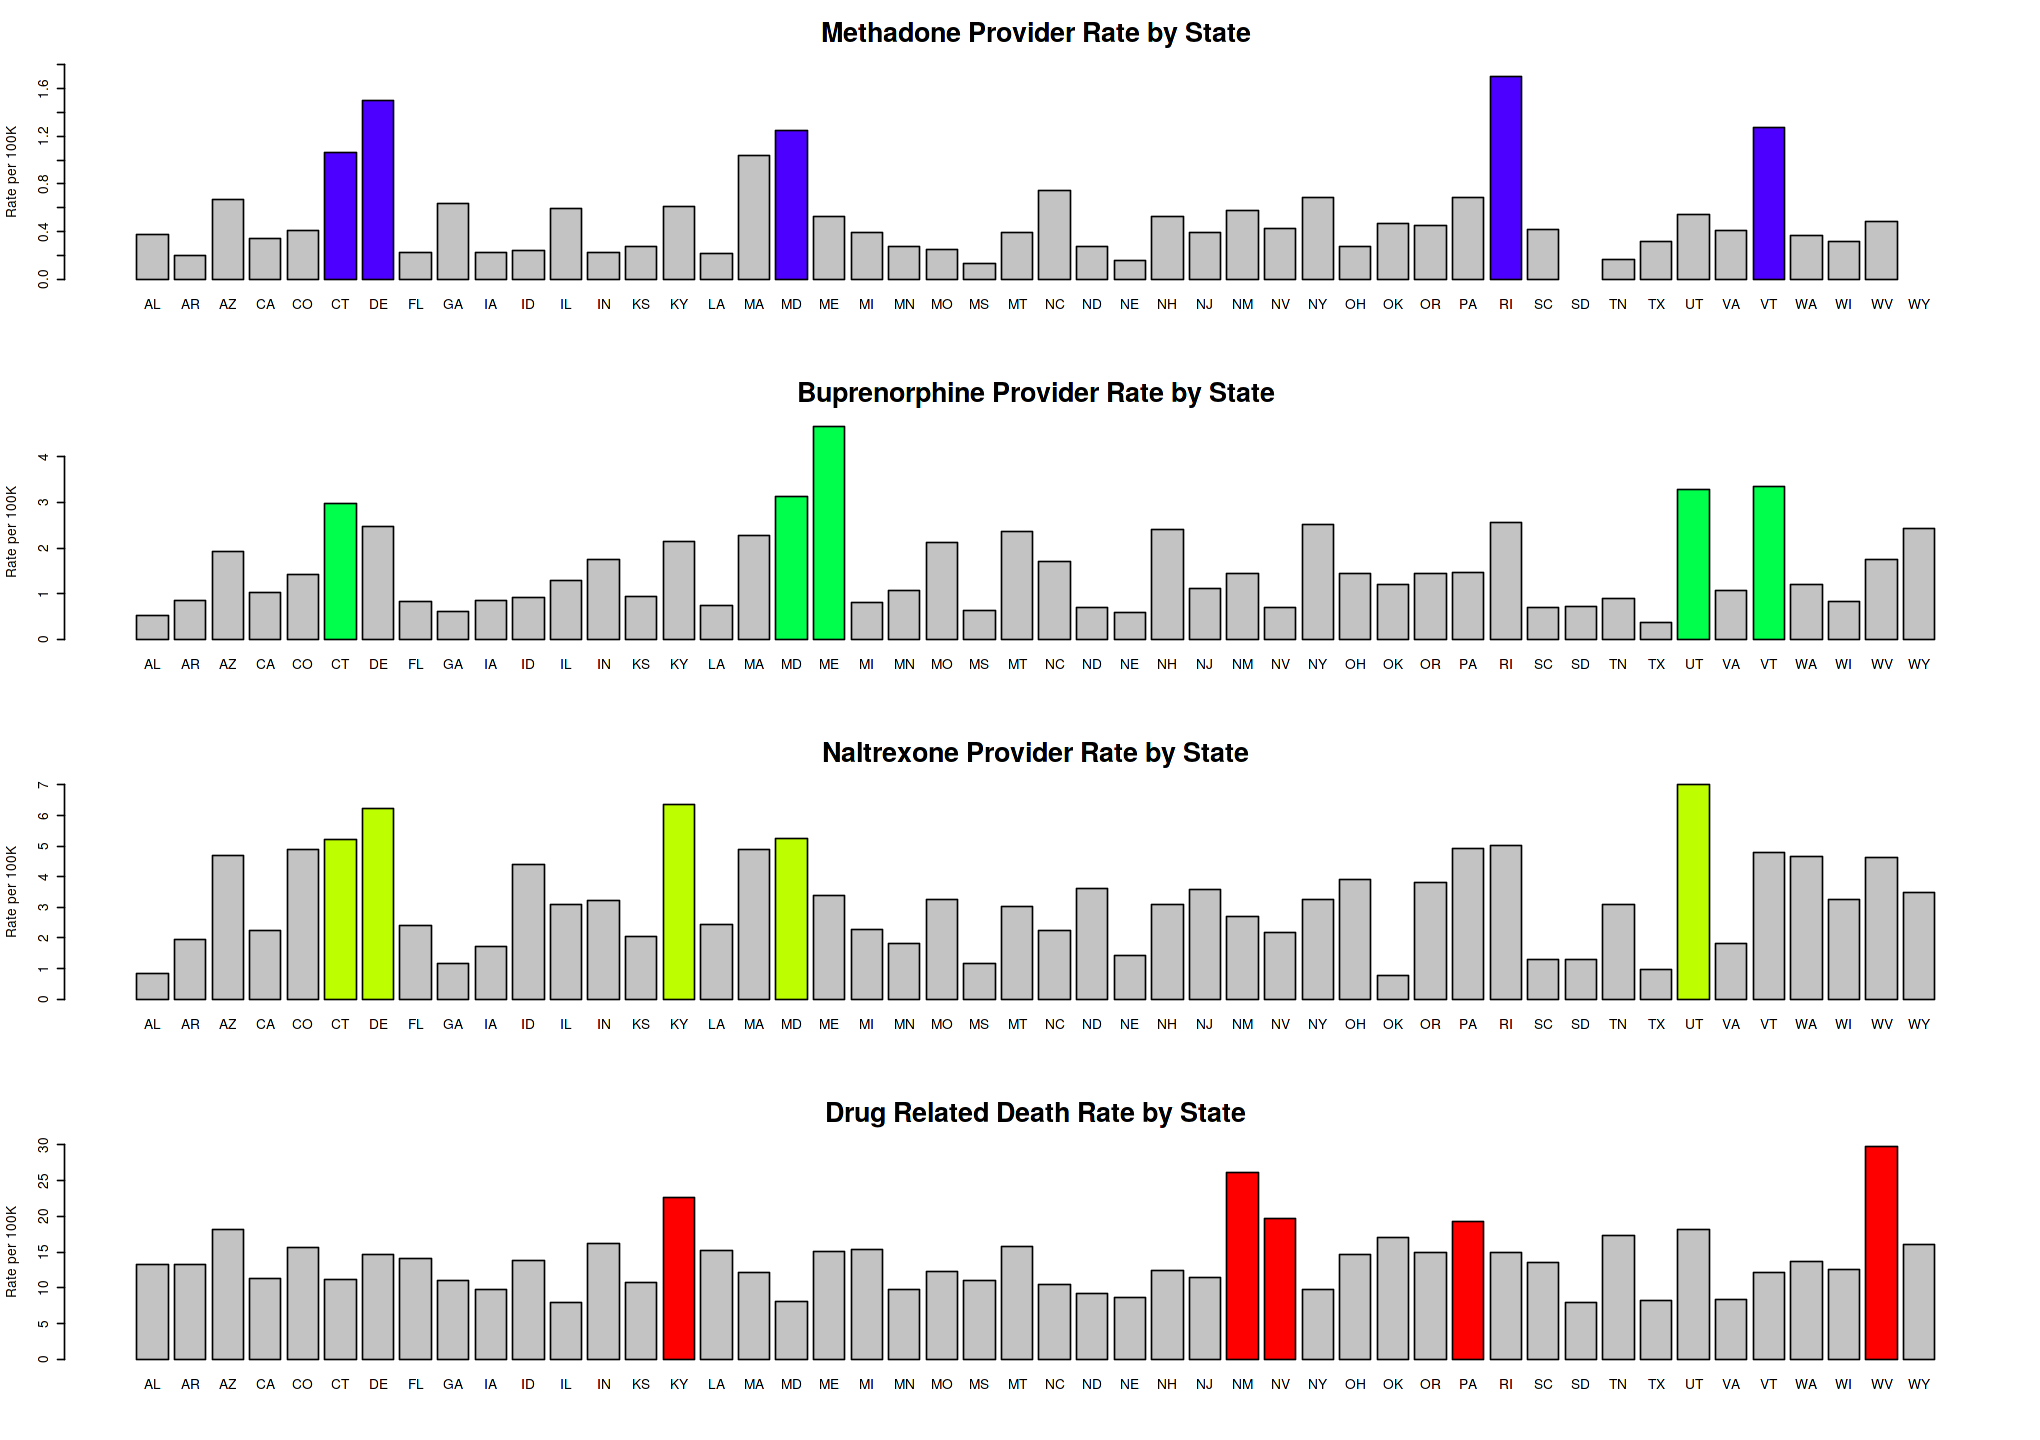

In [10]:
# Find the top 5 states in drug related death rate, methadone rate, buprenorphine rate, and naltrexone rate
death_top5 <- MOUD_death_pop %>% arrange(desc(rawDeathRt)) %>% subset(select=state) %>% head(n=5) %>% pull() %>% as.character()
methadone_top5<- MOUD_death_pop %>% arrange(desc(methRt)) %>% subset(select=state) %>% head(n=5) %>% pull() %>% as.character()
buprenorphine_top5<- MOUD_death_pop %>% arrange(desc(bupreRt)) %>% subset(select=state) %>% head(n=5) %>% pull() %>% as.character()
naltrexone_top5<- MOUD_death_pop %>% arrange(desc(nalRt)) %>% subset(select=state) %>% head(n=5) %>% pull() %>% as.character()

# Highlight the top 5 states in drug related death rate, methadone provider rate,
# buprenorphine provider rate, and naltrexone provider rate
state_vector <- MOUD_death_pop['state'] %>% pull() %>% as.character()
death_col <- rep(c("#C3C3C3"),each=48)
death_col[state_vector %in% death_top5] <- "#FF0000"
methadone_col <- rep(c("#C3C3C3"),each=48)
methadone_col[state_vector %in% methadone_top5] <- "#4C00FFFF"
buprenorphine_col <- rep(c("#C3C3C3"),each=48)
buprenorphine_col[state_vector %in% buprenorphine_top5] <- "#00FF4DFF"
naltrexone_col <- rep(c("#C3C3C3"),each=48)
naltrexone_col[state_vector %in% naltrexone_top5] <- "#BDFF00FF"

# Adjust plots arrangement and sizes
options(repr.plot.width=17, repr.plot.height=12)
par(mfrow = c(4,1))

barplot(MOUD_death_pop3[,8], main="Methadone Provider Rate by State",cex.main=2,
  ylab="Rate per 100K",col = methadone_col, ylim=c(0, 1.8), yaxt = "n")
axis(2,at=seq(0, 1.8, by=0.2),labels=TRUE)

barplot(MOUD_death_pop3[,9], main="Buprenorphine Provider Rate by State",cex.main=2,
  ylab="Rate per 100K",col = buprenorphine_col, ylim=c(0, 4.7), yaxt = "n")
axis(2,at=seq(0,4.7, by=1),labels=TRUE)

barplot(MOUD_death_pop3[,10], main="Naltrexone Provider Rate by State",cex.main=2,
  ylab="Rate per 100K",col = naltrexone_col, ylim=c(0, 7), yaxt = "n")
axis(2,at=seq(0,7, by=1),labels=TRUE)

barplot(MOUD_death_pop3[,7], main="Drug Related Death Rate by State",cex.main=2,
  ylab="Rate per 100K",col = death_col, ylim=c(0, 30), yaxt = "n")
axis(2,at=seq(0, 30, by=5),labels=TRUE)

* **West Virginia, New Mexico, Nevada, Pennsylvania, and Kentucky** (marked in red) are the leading states in drug-related death rate. 
* **Rhode island** is the leading state in methadone rate, followed by Delaware, Maryland, Vermont, and Connecticut (marked in blue). **Maine** and **Utah** have the highest rate of Buprenorphine provider rate (marked in green) and naltrexone provider rate (marked in yellow), respectively.
* **South Dakota and Wyoming** have **zero** methadone providers within the state. However, Wyoming isn't one of the states with the lowest drug-related death rate, which indicates a demand for opioid use disorder (OUD) treatment to be filled.
* Among the top five states with the highest drug-related death rate, **Kentucky and Pennsylvania** are the only two states that have relatively higher naltrexone provider rate. **West Virginia, New Mexico, and Nevada** have a low provider rate for all three MOUD categories.
* The figure above revealed noteworthy disparities between drug-related death rate and OUD treatment capacity across all states of the US.  Opioids are currently the main driver of drug overdose deaths([CDC source](https://www.cdc.gov/drugoverdose/deaths/index.html)). However, **scarcity of MOUD providers**, which plays a crucial role in OUD treatment, has been noted in the states that suffer the most from substance abuse.

## MOUD providers that offer more than one category

As mentioned above, a MOUDs provider can appear more than once in the dataframe because it can prescribe multiple MOUD categories. Next, we tried to extract unique MOUD providers from original dataset and create a new column called `all_meds` which includes all the MOUDs that each uique provider can prescribe.

In [12]:
# Some of the provider are able to prescribe more than one category of MOUD
# Extract unique provider and create a new variable for all categories of MOUD that each provider is able to prescribe
moud_uniq <- moud_noduplicate %>% arrange(desc(full_address),desc(category)) %>% group_by(full_address) %>% mutate(all_meds = paste0(category, collapse = ",")) 
moud_uniq <- moud_uniq %>% distinct(full_address, .keep_all=TRUE)
moud_uniq[1:5,c(16,17)]

full_address                                                                                                                                                 
1 Zuckerberg San Francisco General , Opiate Treatment Outpatient Program , 1001 Potrero Avenue , Building 90, 3rd Floor , San Francisco , CA , 94110           
2 Zucker Hillside Hospital Northwell , Addiction Recovery Services/Daehrs , 7559 263rd Street , Littauer Building Zucker Hillside Hosp , Glen Oaks , NY , 11004
3 Zion Recovery Services , NA , 1500 East 10th Street , NA , Atlantic , IA , 50022                                                                             
4 Zepf Center , NA , 2005 Ashland Avenue , Attention Norine Wasielewski , Toledo , OH , 43620                                                                  
5 Zablocki Veterans Affairs Medical Ctr , NA , 5000 West National Avenue , NA , Milwaukee , WI , 53295                                                         
  all_meds                                   
1 methadone,buprenorphine                    
2 naltrexone/vivitrol,buprenorphine          
3 naltrexone/vivitrol                        
4 naltrexone/vivitrol,methadone,buprenorphine
5 naltrexone/vivitrol,buprenorphine

Below is a summary count table for the variable `all_meds`.

In [13]:
# The counts of MOUD providers that offer multiple MOUD categories
moud_uniq %>% group_by(all_meds) %>% summarise(n = n()) %>% arrange(desc(n))

all_meds                                    n   
1 naltrexone/vivitrol                         6141
2 naltrexone/vivitrol,buprenorphine           2470
3 buprenorphine                                612
4 methadone,buprenorphine                      601
5 naltrexone/vivitrol,methadone,buprenorphine  486
6 methadone                                    326
7 naltrexone/vivitrol,methadone                 44

* The number of unique MOUD providers in the US is **10,680** in this dataset.
* There are only **486 unique MOUD providers (< 5%)** that can offer all three categories of MOUD.
* As expected, the naltrexone providers alone (**6,141**) account for over half of all the unique MOUD providers in the US, given the fact that naltrexone is not classified as a controlled substance.
* Because naltrexone treatment requires full detoxification, initiating treatment among active opioid users is more difficult with this treatment approach.
* Buprenorphine, a partial opioid agonist, is most widely used in combination with the short-acting opiate antagonist naltrexone. The commercial brand for this combined medication is Suboxone. There are **2,470** MOUD providers across the country that can offer both buprenorphine and naltrexone.
* Both methadone and  buprenorphine can be used as maintenance medications. At the doses prescribed, maintenance medications can minimize withdrawal symptoms and cravings in the patient without producing a euphoric high. Because there is a risk of diversion to the illicit market, both medications are classified as the controlled substance. There are only **1,457 providers (13.6%)** out of all unique MOUD providers that can prescribe methadone.

## MOUDs providers distribution at county level across the United States

We first calcualted MOUDs rate in each category at county level. Below is the `shp` file that was used to define county boundaries on the map.

In [14]:
# Read the shape fiel of US counties
county_sf <- st_read("counties2018.shp")

# Show first 5 counties from IL in county shapefile 
county_sf %>% filter(STATEFP=="17") %>% head(n=5)

Reading layer `counties2018' from data source 
  `/home/qiong/JINK/PXP-9010_JCOIN_MOUD_notebook/OEPS_download_files/counties2018.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 3142 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -179.1489 ymin: 18.91036 xmax: 179.7785 ymax: 71.36516
CRS:           4326


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



STATEFP GEOID NAME     TotBed PITCt YrBed geometry                      
1 17      17091 Kankakee    88     86    88 MULTIPOLYGON (((-88.2515 41...
2 17      17187 Warren       0      0     0 MULTIPOLYGON (((-90.78965 4...
3 17      17197 Will       716    539   716 MULTIPOLYGON (((-88.26127 4...
4 17      17027 Clinton      0      0     0 MULTIPOLYGON (((-89.70695 3...
5 17      17031 Cook     18971  16404 18488 MULTIPOLYGON (((-88.26364 4...

In [15]:
dim(county_sf)

[1] 3142    7

* There are 3142 counties in the county shape file

We created a dataframe with MOUDS provider counts in each category at county level, and then merged it with the county shape (`shp`) dataframe. Notice that there are a lot of counties in the US with no MOUD provider.

In [16]:
# calculate the count of MOUD in each category within each county
methadone_county <- moud_noduplicate %>% filter(category=="methadone") %>% group_by(countyGEOID) %>% tally()
buprenorphine_county <- moud_noduplicate %>% filter(category=="buprenorphine") %>% group_by(countyGEOID) %>% tally()
naltrexone_county <- moud_noduplicate %>% filter(category=="naltrexone/vivitrol") %>% group_by(countyGEOID) %>% tally()
colnames(methadone_county)[2]<-"methadone_count"
colnames(buprenorphine_county)[2]<-"buprenorphine_count"
colnames(naltrexone_county)[2]<-"naltrexone_count"

# merge the count of MOUD providers with the county_sf 
county_sf_moud <- merge(county_sf, methadone_county, by.x='GEOID', by.y="countyGEOID", all.x=TRUE) %>% merge(buprenorphine_county, by.x='GEOID', by.y="countyGEOID", all.x=TRUE) %>% merge(naltrexone_county, by.x='GEOID', by.y="countyGEOID", all.x=TRUE)
county_sf_moud %>% head(n=5)

GEOID STATEFP NAME    TotBed PITCt YrBed methadone_count buprenorphine_count
1 01001 01      Autauga  0      0     0    NA              NA                 
2 01003 01      Baldwin 51     28    51    NA              NA                 
3 01005 01      Barbour  0      0     0    NA              NA                 
4 01007 01      Bibb     0      0     0    NA              NA                 
5 01009 01      Blount   0      0     0    NA              NA                 
  naltrexone_count geometry                      
1 NA               MULTIPOLYGON (((-86.9212 32...
2 NA               MULTIPOLYGON (((-88.02858 3...
3 NA               MULTIPOLYGON (((-85.74803 3...
4 NA               MULTIPOLYGON (((-87.42194 3...
5 NA               MULTIPOLYGON (((-86.96336 3...

### How many counties have no MOUD providers under certain category

Below is a summary table of MOUDs counts at county level in the US.

In [17]:
# Print the summary of columns of methadone, buprenorphine, and naltrexone counts 
summary(county_sf_moud[,c("methadone_count","buprenorphine_count","naltrexone_count")] %>% st_set_geometry(NULL))

 methadone_count  buprenorphine_count naltrexone_count
 Min.   : 1.000   Min.   :  1.00      Min.   :  1.00  
 1st Qu.: 1.000   1st Qu.:  1.00      1st Qu.:  1.00  
 Median : 1.000   Median :  2.00      Median :  2.00  
 Mean   : 2.365   Mean   :  3.85      Mean   :  6.17  
 3rd Qu.: 2.000   3rd Qu.:  4.00      3rd Qu.:  6.00  
 Max.   :47.000   Max.   :104.00      Max.   :202.00  
 NA's   :2529     NA's   :2065        NA's   :1661    

* Out of 3,142 counties, 2,529 counties have no methadone providers, 2,065 counties have no buprenorphine providers, and 1,661 counties have no naltrexone providers.

### How many counties don't have any MOUD provider

We also calcualted the number of counties in the US don't have any MOUDs provider.

In [17]:
# combine county level moud providers 
merged_county_moud <- merge(methadone_county, buprenorphine_county, by='countyGEOID', all=TRUE) %>% merge(naltrexone_county, by='countyGEOID', all=TRUE)
3142-dim(merged_county_moud)[1]

[1] 1540

* Out of 3,142 counties, 1,540 counties don't have any MOUD providers (methadone, buprenorphine, or naltrexone)

### Unique MOUD providers distribution at county level

We counted the unique MOUDs providers in each county across the country. We merged this dataframe with another table of drug related death rate at county level, which includes estimated county population. The population column was then used to calcualte the MOUDs rate (unique providers) in each county.

In [18]:
# Clean up the unique moud dataset by removing the MOUD without countyGEOID
# For instance county from Puerto Rico doesn't have county GEOID
moud_uniq_subset <- moud_uniq[!(is.na(moud_uniq$countyGEOID)),]

moud_uniq_county_count <- moud_uniq_subset %>% group_by(countyGEOID)%>% tally()

In [19]:
# Read county level drug-related death rate file
OD_death_c <- read.csv("Health01_C.csv",
                      stringsAsFactors=FALSE, colClasses=c("COUNTYFP"="character", "state.code"="character"))

OD_death_c$state.code <- str_pad(OD_death_c$state.code, 2, pad = "0")
OD_death_c$COUNTYFP <- str_pad(OD_death_c$COUNTYFP, 5, pad = "0")

# The Population of each county is an aggrevation over 10 years (09-18)
OD_death_c$pop <- OD_death_c$pop/10
OD_death_c[1:5,]

COUNTYFP county             state.code state   deaths pop      rawDeathRt
1 01001    Autauga County, AL 01         Alabama  54     55199.6  9.8      
2 01003    Baldwin County, AL 01         Alabama 257    197775.1 13.0      
3 01005    Barbour County, AL 01         Alabama  17     26600.2  6.4      
4 01007    Bibb County, AL    01         Alabama  41     22653.1 18.1      
5 01009    Blount County, AL  01         Alabama 111     57698.7 19.2

In [20]:
# Calculate the unique MOUD providers rate per 100K population in each county
OD_death_c_uniq_moud <- merge(OD_death_c, moud_uniq_county_count, by.x='COUNTYFP', by.y='countyGEOID', all.x=TRUE)
colnames(OD_death_c_uniq_moud)[8] <- "unique_moud"

OD_death_c_uniq_moud$moud_rate <- (OD_death_c_uniq_moud$unique_moud/OD_death_c_uniq_moud$pop)*100000

In [21]:
OD_death_c_uniq_moud[!(is.na(OD_death_c_uniq_moud$unique_moud)),] %>% arrange(desc(moud_rate)) %>% head(n=5)

COUNTYFP county              state.code state     deaths pop     rawDeathRt
1 21127    Lawrence County, KY 21         Kentucky   43    15819.0 27.2      
2 51640    Galax city, VA      51         Virginia   14     6868.5 20.4      
3 08003    Alamosa County, CO  08         Colorado   38    16140.6 23.5      
4 47101    Lewis County, TN    47         Tennessee  23    12002.3 19.2      
5 21071    Floyd County, KY    21         Kentucky  217    38106.8 56.9      
  unique_moud moud_rate
1  9          56.89361 
2  3          43.67766 
3  7          43.36890 
4  5          41.65868 
5 13          34.11465

* The county with the highest MOUD rate (56.9 MOUD providers per 100K population) is **Lawrence County, Kentucky**.
* The top counties with high MOUD rate also have high drug-related death rate as shown above.

We then plotted the unique MOUD provider rate in each county below. The drug related death rate at county level was also plotted to show the disparities between drug-related death rate and OUD treatment capacity.

In [22]:
# Plot county level moud rate and drug related death rate on map

# merge with county_sf dataframe
county_sf_uniq_moud <- merge(county_sf, OD_death_c_uniq_moud, by.x='GEOID', by.y="COUNTYFP", all.x=TRUE)

# Two states and DC to exclude from the map for display
exclude_states <- c("02","11","15")
county_sf_uniq_moud_subset <- county_sf_uniq_moud[!(county_sf_uniq_moud$STATEFP %in% exclude_states),]

# Read the state shape file for plotting state boundaries
state_sf <- st_read("states2018.shp")
state_sf_subset <- state_sf[!(state_sf$STATEFP %in% exclude_states),]

Reading layer `states2018' from data source 
  `/home/qiong/JINK/PXP-9010_JCOIN_MOUD_notebook/OEPS_download_files/states2018.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 51 features and 12 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -179.1489 ymin: 18.91036 xmax: 179.7785 ymax: 71.36516
CRS:           4326


tmap mode set to plotting



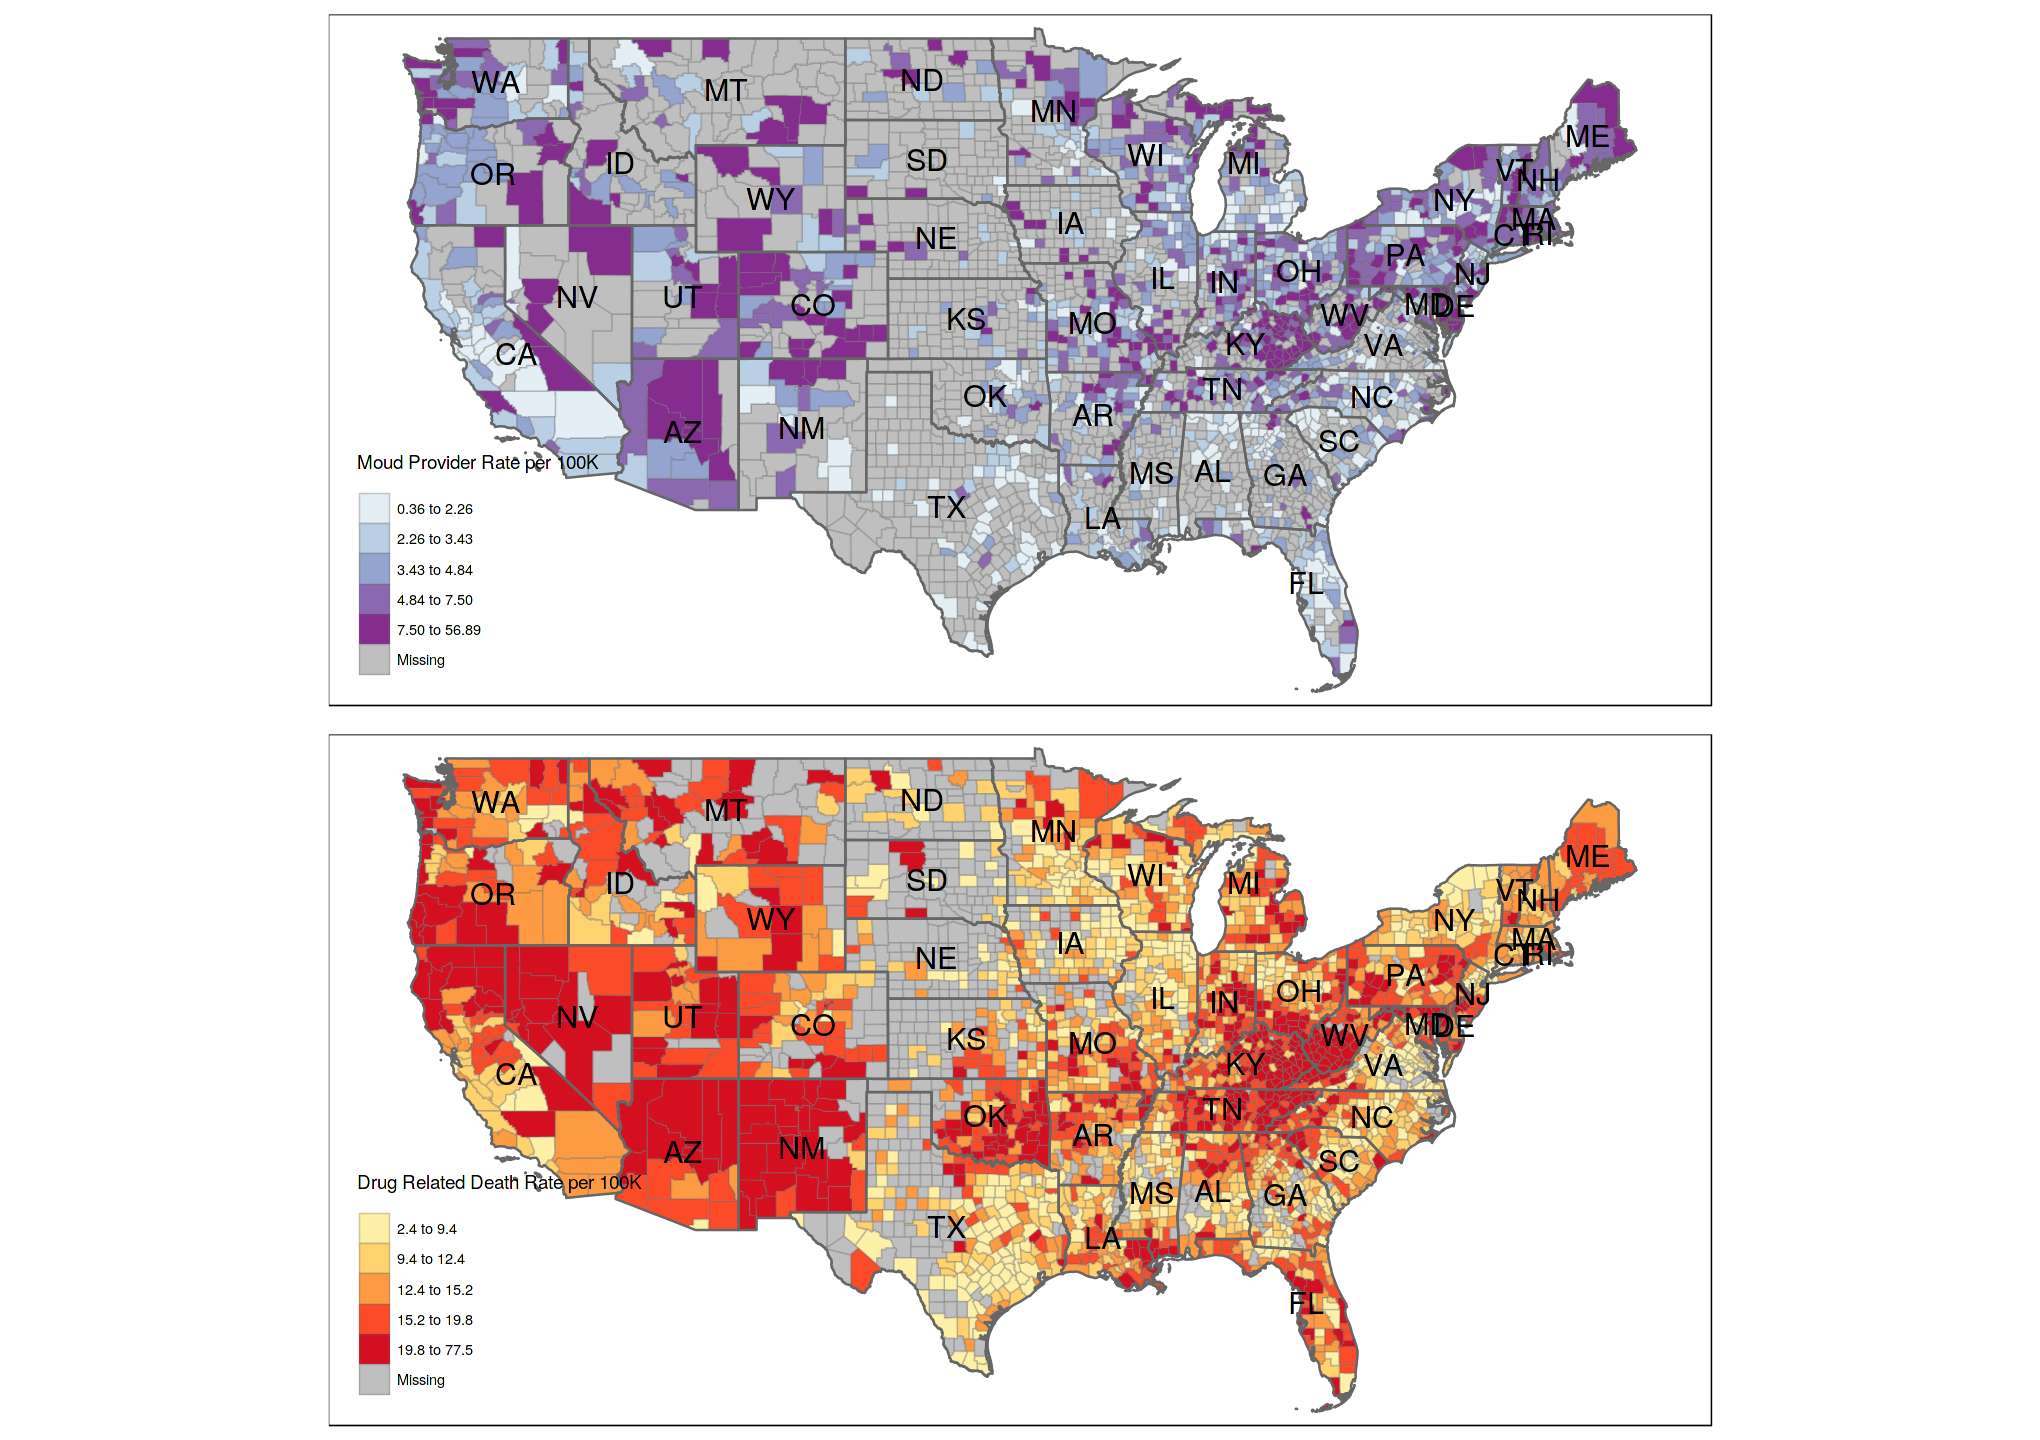

In [26]:
# Plot county level moud rate and death rate
options(repr.plot.width=17, repr.plot.height=12)

tmap_mode("plot")
tm_moud_unique <- tm_shape(county_sf_uniq_moud_subset) + tm_borders(alpha = 0.3) +
    tm_polygons("moud_rate", style="quantile",pal="BuPu",
              title = "Moud Provider Rate per 100K") +
    tm_shape(state_sf_subset) + tm_borders(lwd=1.5) + tm_text("STUSPS", size=1.5)+
    tm_layout(legend.stack = "horizontal") 

tm_death_rate<-tm_shape(county_sf_uniq_moud_subset) + tm_borders(alpha = 0.3) +
    tm_polygons("rawDeathRt", pal="YlOrRd", style="quantile"
               , title = "Drug Related Death Rate per 100K") +
    tm_shape(state_sf_subset) + tm_borders(lwd = 1.5)  + tm_text("STUSPS", size=1.5) +
    tm_layout(legend.stack = "horizontal")

tmap_arrange(tm_moud_unique, tm_death_rate)

* The county level drug-related death rate on the map revealed the severity and prevalence of drug abuse along the **Appalachian regions**. 
* A high drug -elated death rate is also observed in a large amount of counties in the **west region of the US**.
* The disparities between drug-related death rate and OUD treatment capacity are noted for several states from the figure above. For some states, a high death rate and low moud provider rate have been seen in the majorites of the counties, such as **New Mexico, Nevada, Oklahoma, and Tennessee**.

### MOUD rate and drug related death rate of Appalachian counties

The Appalachian region suffers a higher opioid overdose mortality rate comapred to the rest of the country. Below shows zoomed-in plots of unique MOUD providers rate and drug related death rate of Appalacgian counties on map.

In [27]:
# Download a list of counties that belong to the Appalachian region
appalachian_counties <-read_csv("https://gist.githubusercontent.com/akanik/979b38bfd3afa797ec33944fac7e26d7/raw/491add919d0ba147dc0fcc1616575affe5371e3e/arc-gov-appal-counties.csv")
appalachian_counties <- as.data.frame(appalachian_counties)
appalachian_counties$county[appalachian_counties$county=="De Kalb"] <- "DeKalb"
appalachian_counties$county <- paste(appalachian_counties$county, ",",appalachian_counties$state)

# Generate a translation table between county, state and GEOID
county_fips <- county_sf[,c('STATEFP','GEOID','NAME')] %>% st_set_geometry(NULL)
state_fips <- state_sf[,c('GEOID','NAME')] %>% st_set_geometry(NULL)
colnames(state_fips)[2] <- "state_name" 
county_fips <- merge(county_fips, state_fips, by.x='STATEFP', by.y='GEOID', all.x=TRUE)
county_fips$county<- paste(county_fips$NAME, ",", county_fips$state_name)

# Add GEOID to the Appalachian dataframe
appalachian_counties_fips <- merge(appalachian_counties, county_fips, 
                              by='county', all.x=TRUE)



── Column specification ──────────────────────────────────────────────────────
cols(
  state = col_character(),
  county = col_character()
)




In [28]:
# Filter the county_sf_uniq_moud_subset based on the Appalachian region
appalachian_county_sf_uniq_moud <- county_sf_uniq_moud_subset[(county_sf_uniq_moud_subset$GEOID %in% appalachian_counties_fips$GEOID),]

tmap mode set to plotting



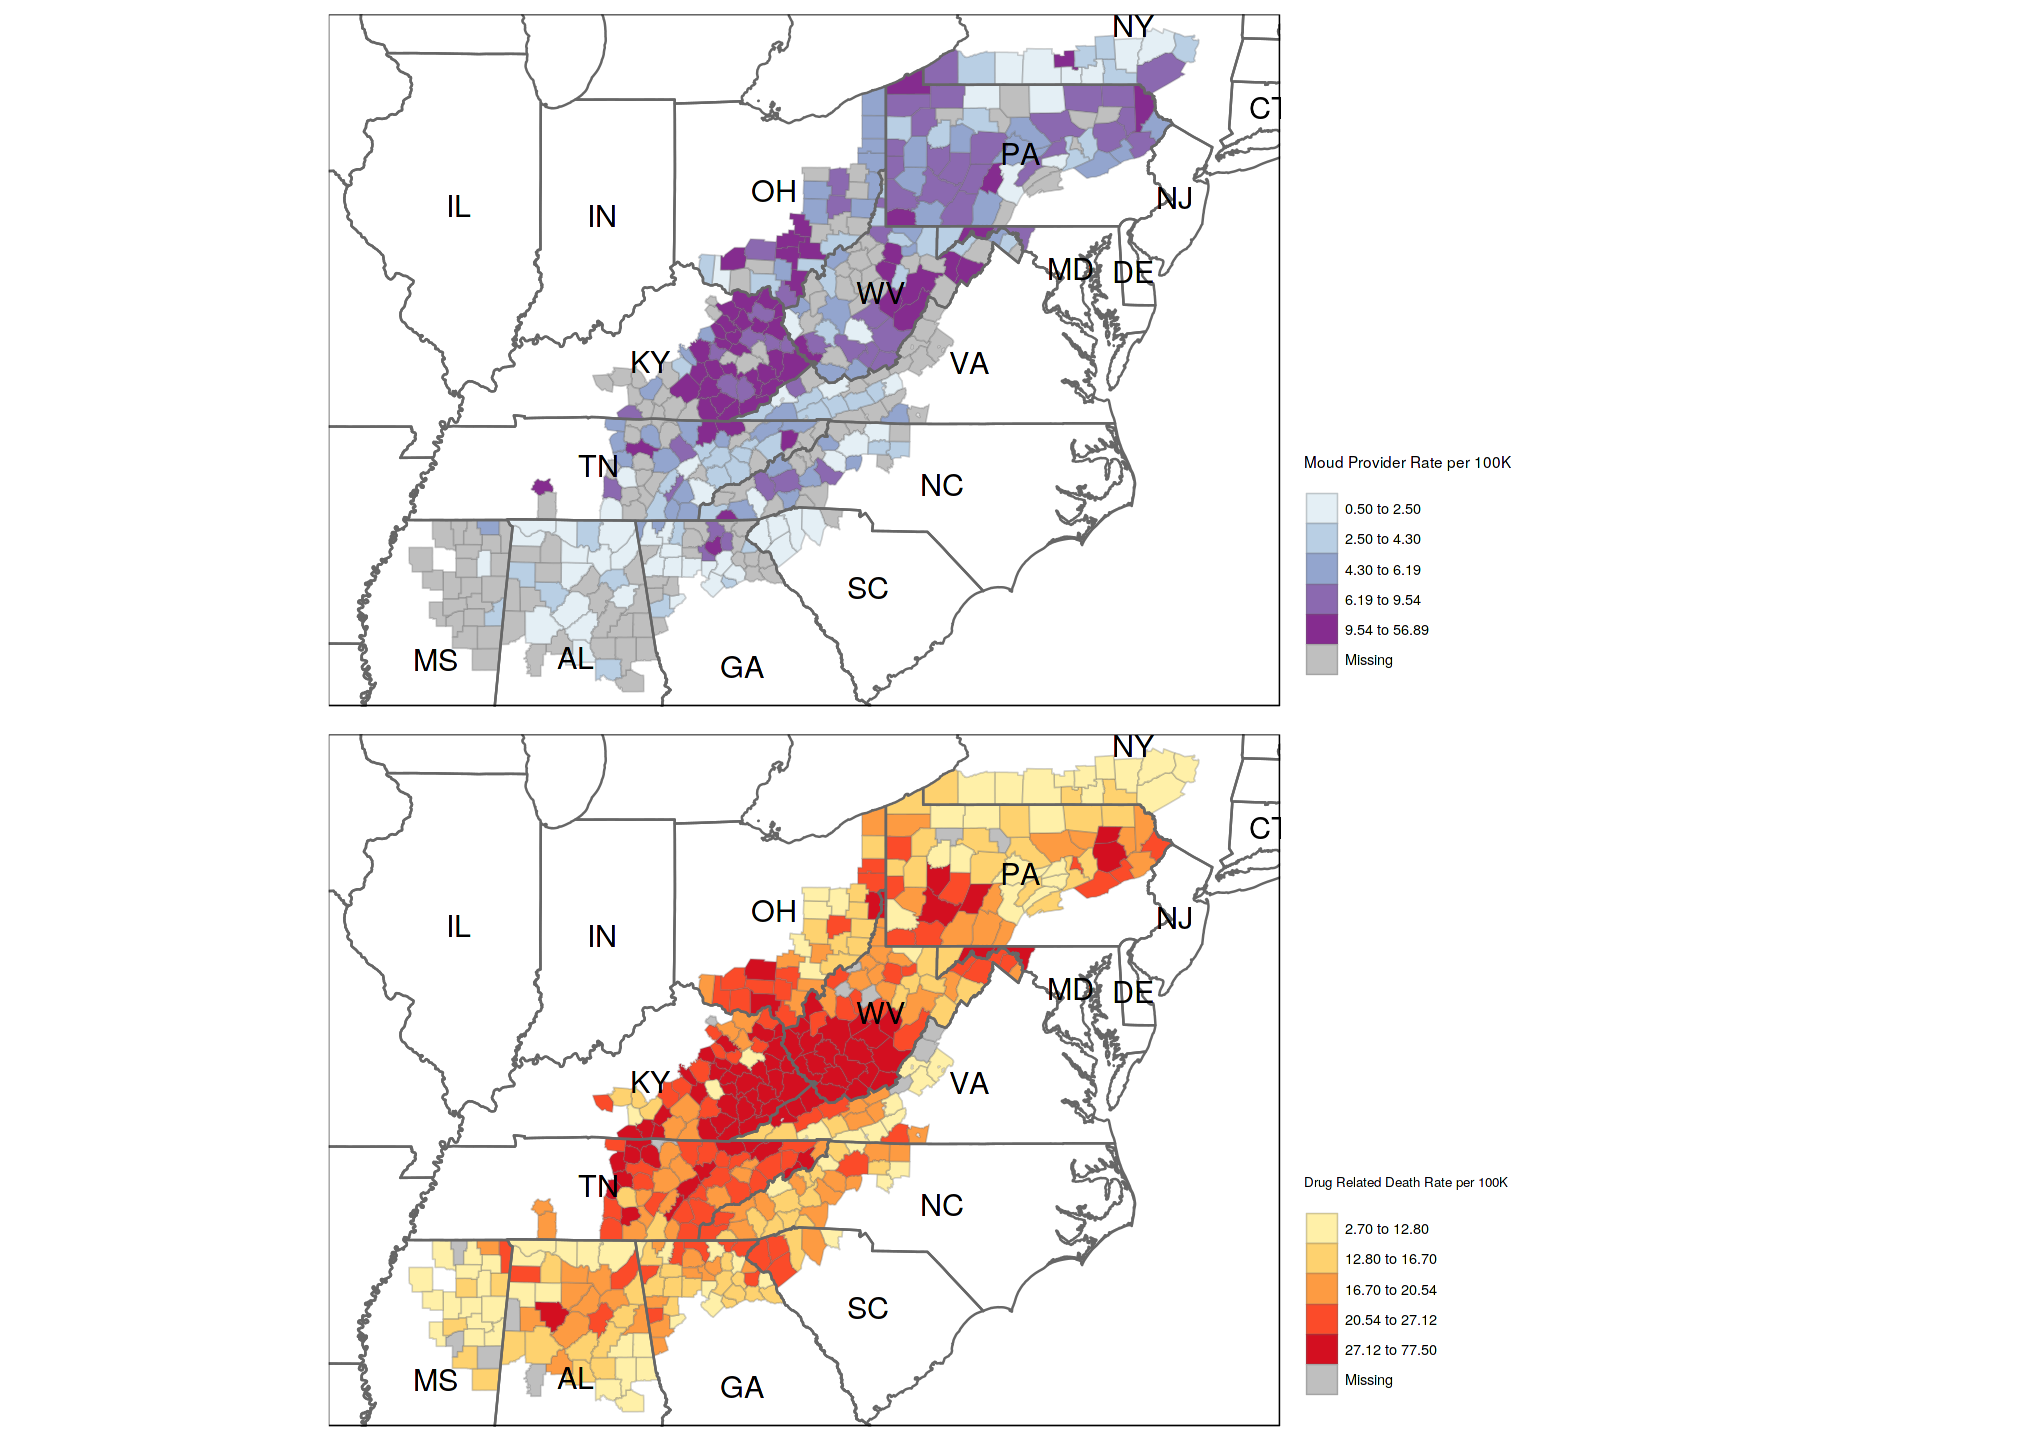

In [29]:
# Plot Appalachian counties on map with MOUD rate and drug-related death rate
options(repr.plot.width=17, repr.plot.height=12)

tmap_mode("plot")
tm_moud_unique_app <- tm_shape(appalachian_county_sf_uniq_moud) + tm_borders(alpha = 0.3) +
    tm_polygons("moud_rate", style="quantile",pal="BuPu",
              title = "Moud Provider Rate per 100K") +
    tm_shape(state_sf_subset) + tm_borders(lwd=1.5) + tm_text("STUSPS", size=1.5)+
    tm_layout(legend.outside=TRUE,legend.position=c("right", "bottom")) 

tm_death_rate_app<-tm_shape(appalachian_county_sf_uniq_moud) + tm_borders(alpha = 0.3) +
    tm_polygons("rawDeathRt", pal="YlOrRd", style="quantile"
               , title = "Drug Related Death Rate per 100K") +
    tm_shape(state_sf_subset) + tm_borders(lwd = 1.5)  + tm_text("STUSPS", size=1.5) +
    tm_layout(legend.outside=TRUE,legend.position=c("right", "bottom"))

tmap_arrange(tm_moud_unique_app, tm_death_rate_app)

* The Appalachian region suffers a 72 percent higher opioid overdose mortality rate compared to the non-Appalachian counties throughout the United States([Source](https://oig.hhs.gov/oei/reports/OEI-05-19-00410.asp)). The zoomed-in visualization of the Appalachian region revealed a cluster of counties with a noteworthy high death rate around the tristate area (east of KY, southwest of WV, and west of VA).
* Almost every county in the south of West Virginia is found with a high drug-related death rate. However, the low capacity of MOUD providers is noted in the majority of the southern counties of WV. 
* It is noteworthy to mention that a lot of counties along the Appalachian region have no MOUD providers (marked in grey as Missing)

In [30]:
summary(appalachian_county_sf_uniq_moud[,c("moud_rate", "rawDeathRt")], na.rm=TRUE)

   moud_rate         rawDeathRt             geometry  
 Min.   : 0.4963   Min.   : 2.70   MULTIPOLYGON :420  
 1st Qu.: 3.0672   1st Qu.:14.20   epsg:4326    :  0  
 Median : 5.2039   Median :18.40   +proj=long...:  0  
 Mean   : 7.0308   Mean   :20.76                      
 3rd Qu.: 8.7778   3rd Qu.:25.00                      
 Max.   :56.8936   Max.   :77.50                      
 NA's   :153       NA's   :15                         

* Among over 400 Appalachian counties, a total of 153 Appalachian counties don't have any MOUD provider (nearly 1/3). 
* The average drug-related death rate in Appalachian counties is 20.76 per 100K population.

## Identifying high risk counties with high drug related death rate and low capacity of MOUDs

Below is the summary of drug related death rate and unique MOUDs rate at county level. We then used the medium number as threshold to identify the high risk counties in the US.

In [35]:
OD_death_c_uniq_moud[,c("rawDeathRt", "moud_rate")] %>% summary(na.rm=TRUE)

   rawDeathRt      moud_rate      
 Min.   : 2.40   Min.   : 0.3636  
 1st Qu.:10.20   1st Qu.: 2.5149  
 Median :13.80   Median : 4.0844  
 Mean   :15.37   Mean   : 5.4243  
 3rd Qu.:18.40   3rd Qu.: 6.6604  
 Max.   :77.50   Max.   :56.8936  
 NA's   :1       NA's   :960      

* The mean of the county level drug-related death rate (15.37) and the mean of the county level MOUD provider rate (5.4243) will be used as the threshold to identify high risk counties. 
* Please note that there are 960 counties that don't have any MOUD provider. The mean of MOUD rate at the county level was calculated based on counties with at least one provider.

We calculated how many counties in the US were considered as high risk county using the threshold mentioned above.

In [36]:
# The counties with moud_rate as NA means there is no moud provider within the county
county_sf_uniq_moud$moud_rate[is.na(county_sf_uniq_moud$moud_rate)] <- 0

high_risk_counties_sf <- county_sf_uniq_moud[!(is.na(county_sf_uniq_moud$rawDeathRt)), ] %>% filter(moud_rate <=5.4243 & rawDeathRt >=15.37)

In [37]:
high_risk_counties_sf %>% dim()

[1] 675  15

Below shows how many states have at least one high risk county and the leading states with the highest nunber of high risk counties.

In [38]:
high_risk_counties_sf %>% group_by(state) %>% tally() %>% dim()
high_risk_counties_sf %>% group_by(state) %>% tally() %>% arrange(desc(n)) %>% head(n=5)

[1] 46  3

state     n  geometry                      
1 Tennessee 57 MULTIPOLYGON (((-85.02674 3...
2 Oklahoma  51 MULTIPOLYGON (((-99.36422 3...
3 Kentucky  40 MULTIPOLYGON (((-86.41898 3...
4 Georgia   35 MULTIPOLYGON (((-83.14152 3...
5 Florida   27 MULTIPOLYGON (((-80.88122 2...

* There are a total of 675 high risk counties (high drug related death rate and low MOUD capacity) across 46 states. 
* Tennessee(TN), Oklahoma(OK), Georgia(GA), Kentucky(KY), and Texas(TX) are the leading states with the highest number of high risk counties.
* The State of Tennessee has the most high risk counties from this analysis. A large number of Tennessee counties with high drug-related death rate have no MOUD provider.

We summed up the population of all high risk counties from the same state, and calcualted the high risk population percentage for each state. The table below shows the leading states with highest population percentage affected by the high risk of MOUDs accessibility.

In [44]:
high_risk_pop <- high_risk_counties_sf %>% group_by(state) %>% summarise(hs_pop = sum(pop)) %>% st_set_geometry(NULL)
high_risk_pop$state <- state.abb[match(high_risk_pop$state,state.name)]
high_risk_pop <- merge(high_risk_pop, OD_death_S[,c("state","pop")], by.x="state", by.y="state", all.x=TRUE)

# Calculate the percentage of population in high risk counties
high_risk_pop$hs_percent <- (high_risk_pop$hs_pop/high_risk_pop$pop)*100

# Summary of high risk population percent
summary(high_risk_pop$hs_percent, na.rm=TRUE)
# Show states with highest and low portion of high risk county population
high_risk_pop %>% arrange(desc(hs_percent)) %>% head()
high_risk_pop %>% arrange(hs_percent) %>% head()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.2537  8.6716 24.8110 28.6094 44.6554 94.9527       1 

state hs_pop  pop     hs_percent
1 NV    2692863 2836004 94.95274  
2 NM    1534561 2078422 73.83298  
3 OK    2839323 3851271 73.72431  
4 AZ    4361741 6707609 65.02676  
5 MI    6348883 9915938 64.02706  
6 WV    1064858 1841310 57.83155

state hs_pop   pop        hs_percent
1 IL     32564.0 12833927.4 0.2537337 
2 NE     14152.9  1873985.9 0.7552298 
3 ND      9215.7   721434.3 1.2774136 
4 SD     18151.2   845255.9 2.1474207 
5 NY    521173.6 19605066.8 2.6583618 
6 TX    748820.6 26742450.8 2.8001196

* Among states with high risk counties, an average of 28.61% state population is affected by a high drug-related death rate and low MOUD capacity.
* Over 90% of the population in Nevada is found in high risk counties. Other leading states are New Mexico (NM) (73.83%), Oklahoma(73.72%), Arizona (65.0%), Michigan (62%) and WV (57%). 
* Only 0.25% of the IL populations are found in high risk counties. Other states with a small portion of population in high risk counties are Nebraska, North Dakota, South Dakota, New York, and Texas.

We then plotted these high risk counties on the map. Each dot represents a high risk county on the map. The size and the color of the dot coresponds to the drug related death rate of higher risk county.

tmap mode set to plotting



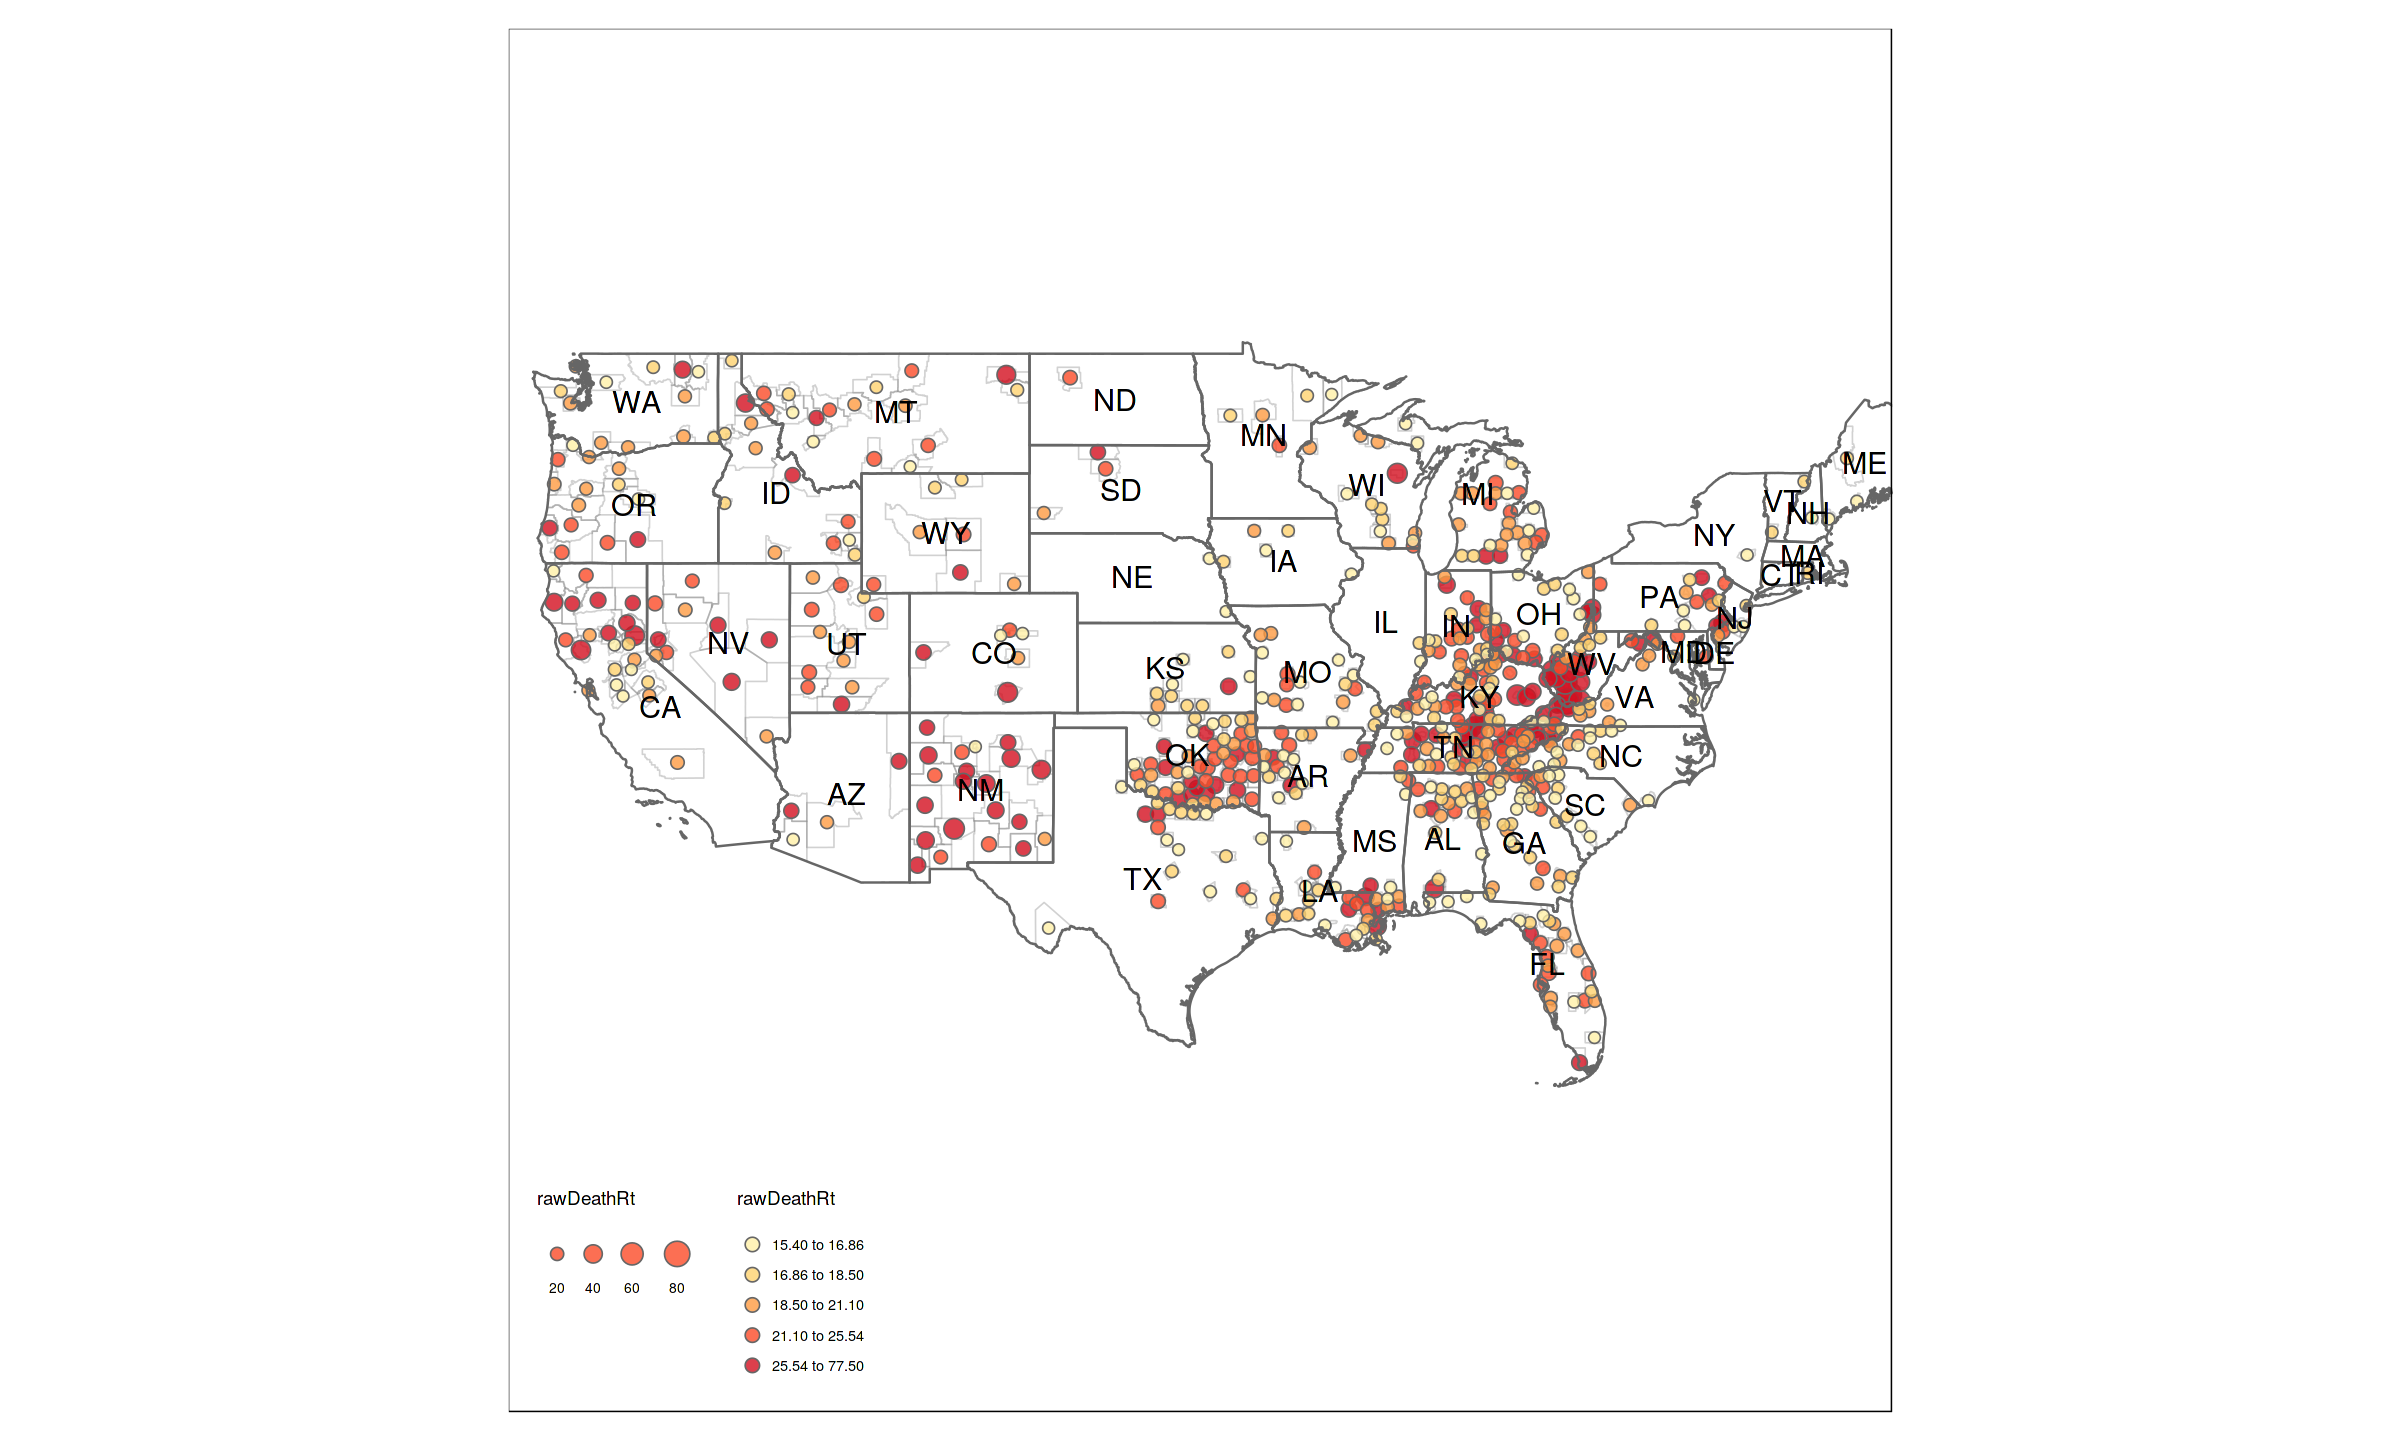

In [57]:
# Three states to exclude from the map
exclude_states <- c("02","11","15")
high_risk_counties_sf_subset <- high_risk_counties_sf[!(high_risk_counties_sf$state.code %in% exclude_states),]

# Plot Appalachian counties on map with MOUD rate and drug related death rate
options(repr.plot.width=20, repr.plot.height=12)

tmap_mode("plot")

tm_high_risk_death<-tm_shape(high_risk_counties_sf_subset) + tm_borders(alpha = 0.3) +
    tm_bubbles(size="rawDeathRt", alpha=0.8, col = "rawDeathRt", pal="YlOrRd", 
               style="quantile") +
    tm_shape(state_sf_subset) + tm_borders(lwd = 1.5)  + tm_text("STUSPS", size=1.5) +
    tm_layout(legend.stack = "horizontal")

tmap_arrange(tm_high_risk_death)

* The map of high risk counties (high drug-related death rate and low MOUD capacity) show a huge cluster of high risk counties in the southwest area of the Appalachian region (**Kentucky, Tennessee, and Georgia**). 
* In the south-central region of US, **Oklahoma** is the leading state with the highest number of high risk counties.
* Higher density of high risk counties is also observed in East North Central states, such as **Michigan, Indiana, and Ohio**.

## Key takeaways
* This analysis revealed noteworthy disparities between drug-related death rate and MOUD treatment capacity in **the Appalachian region, south region, and pacific region of the United States**.
* Over 80% of the counties don't have any methadone providers. Half of the counties in the US don't have any moud providers. 
* Both methadone and buprenorphine have shown promising results as an opioid addiction maintenance medication in clinical trials. However, we've seen low accessibility of providers for both medications, especially methadone, across the states. 

## Additional resources for analyzing OEPS data

* [Opioid Environment Toolkit](https://www.jcoinctc.org/resources/opioid-environment-toolkit/)

The Center for Spatial Data Science at UChicago has created an Opioid Environment Toolkit. This toolkit provides an introduction to GIS and spatial analysis for opioid environment applications that allows researchers, analysts, and practitioners to support their communities with better data analytics and visualization services.

* [Jupyter Notebook example using Opioid Environment Toolkit](https://healdata.org/dashboard/Public/notebooks/Opioid_Environment_Toolkit_And_OEPS_R.html)